# N-Gram Setup

## Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wikitext2/test.txt
/kaggle/input/wikitext2/train.txt
/kaggle/input/wikitext103/wikitext-103/wiki.train.tokens
/kaggle/input/wikitext103/wikitext-103/README.txt
/kaggle/input/wikitext103/wikitext-103/LICENSE.txt
/kaggle/input/wikitext103/wikitext-103/wiki.valid.tokens
/kaggle/input/wikitext103/wikitext-103/wiki.test.tokens


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import defaultdict, Counter
import math

## Dataset

In [3]:
class TextLineDataset:
    """
    Dataset that:
    - Reads raw text files
    - Treats each non-empty line as a sequence
    - Uses an external encoder
    - Stores UNPADDED token sequences
    """

    def __init__(self, path, encoder):
        self.path = path
        self.encoder = encoder
        self.lines = self._load_lines(path)
        self.token_sequences = self._encode_lines(self.lines)

    def _load_lines(self, path):
        lines = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.rstrip("\n")
                if line.strip():
                    lines.append(line)
        return lines

    def _encode_lines(self, lines):
        return [self.encoder.encode(line) for line in lines]

    def __len__(self):
        return len(self.token_sequences)

    def __getitem__(self, idx):
        return self.token_sequences[idx]

## Vocabulary

### Character Level

In [4]:
class CharEncoder:
    """
    Character-level encoder.
    Treats all characters literally (including <unk> text).
    """

    BOS = "<s>"
    EOS = "</s>"

    def __init__(self):
        self.char2idx = {}
        self.idx2char = {}

    def build_vocab(self, texts):
        """
        Build vocabulary from training texts only.
        """
        counter = Counter()
        for text in texts:
            for ch in text:
                counter[ch] += 1

        vocab = [self.BOS, self.EOS] + sorted(counter.keys())

        self.char2idx = {ch: i for i, ch in enumerate(vocab)}
        self.idx2char = {i: ch for ch, i in self.char2idx.items()}

    def encode(self, text):
        """
        Encode text into list of tokens (characters).
        """
        return list(text)

    def decode(self, tokens):
        return "".join(tokens)

    def __len__(self):
        return len(self.char2idx)


## Model

In [5]:
class NgramLM:
    """
    Maximum Likelihood Estimation n-gram language model.
    Count-based with pluggable probability estimators.
    """

    def __init__(self, n):
        self.n = n
        self.counts = defaultdict(lambda: defaultdict(int))
        self.context_counts = defaultdict(int)

    # ---------- Training ----------

    def fit(self, sequences):
        for sequence in sequences:
            for i in range(len(sequence) - self.n + 1):
                context = tuple(sequence[i:i + self.n - 1])
                token   = sequence[i + self.n - 1]

                self.counts[context][token] += 1
                self.context_counts[context] += 1

    # ---------- Probability estimators ----------

    def log_prob_mle(self, context, token):
        count = self.counts[context].get(token, 0)
        if count == 0:
            return float("-inf")
        return math.log(count) - math.log(self.context_counts[context])

    def log_prob_laplace(self, context, token, vocab_size):
        count_hw = self.counts[context].get(token, 0)
        count_h  = self.context_counts.get(context, 0)
        return math.log(count_hw + 1) - math.log(count_h + vocab_size)

    def log_prob_add_k(self, context, token, vocab_size, k):
        count_hw = self.counts[context].get(token, 0)
        count_h  = self.context_counts.get(context, 0)
        return math.log(count_hw + k) - math.log(count_h + k * vocab_size)

    def log_prob_interpolated(self, context, token, lambdas, vocab_size, k=0.01):
        """
        Linear interpolation with smoothed unigram.
        """
        assert len(lambdas) == self.n
        assert abs(sum(lambdas) - 1.0) < 1e-6
    
        prob = 0.0
    
        for order in range(1, self.n + 1):
            weight = lambdas[order - 1]
    
            if order == 1:
                # smoothed unigram
                count_hw = self.counts[()].get(token, 0)
                count_h  = self.context_counts.get((), 0)
                prob += weight * ((count_hw + k) / (count_h + k * vocab_size))
            else:
                sub_context = context[-(order - 1):]
                count_hw = self.counts[sub_context].get(token, 0)
                count_h  = self.context_counts.get(sub_context, 0)
    
                if count_h > 0:
                    prob += weight * (count_hw / count_h)
                # else contributes zero
    
        return math.log(prob)

    def log_prob_backoff(self, context, token, alpha=0.4, vocab_size=None, k=0.01):
        """
        Stupid backoff with smoothed unigram termination.
        """
    
        for order in range(self.n, 1, -1):
            sub_context = context[-(order - 1):]
            count_hw = self.counts[sub_context].get(token, 0)
            count_h  = self.context_counts.get(sub_context, 0)
    
            if count_hw > 0 and count_h > 0:
                return math.log(count_hw) - math.log(count_h)
    
        # ---- unigram fallback (smoothed) ----
        count_hw = self.counts[()].get(token, 0)
        count_h  = self.context_counts.get((), 0)
    
        prob = (count_hw + k) / (count_h + k * vocab_size)
        return math.log(prob)


    # ---------- Generic evaluation ----------

    def sequence_log_likelihood(self, sequence, log_prob_fn):
        total = 0.0
        for i in range(len(sequence) - self.n + 1):
            context = tuple(sequence[i:i + self.n - 1])
            token   = sequence[i + self.n - 1]

            lp = log_prob_fn(context, token)
            if lp == float("-inf"):
                return float("-inf")
            total += lp
        return total

    def perplexity(self, sequences, log_prob_fn):
        total_logp = 0.0
        total_tokens = 0

        for seq in sequences:
            ll = self.sequence_log_likelihood(seq, log_prob_fn)
            if ll == float("-inf"):
                return float("inf")

            total_logp += ll
            total_tokens += len(seq) - (self.n - 1)

        return math.exp(-total_logp / total_tokens)

## Experiment Configurations

In [6]:
TRAIN_PATH="/kaggle/input/wikitext2/train.txt"
TEST_PATH="/kaggle/input/wikitext2/test.txt"

In [7]:
def pad_sequences(sequences, n, bos, eos):
    if n < 1:
        raise ValueError("n must be >= 1")

    padded = []
    for seq in sequences:
        padded.append([bos] * (n - 1) + seq + [eos])
    return padded

In [8]:
train_lines = []
with open(TRAIN_PATH, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:
            train_lines.append(line)

encoder = CharEncoder()
encoder.build_vocab(train_lines)

train_dataset = TextLineDataset(TRAIN_PATH, encoder)
test_dataset  = TextLineDataset(TEST_PATH, encoder)

## Visualization Utilities

In [9]:
def unpack_results(results):
    return {
        "n": [r["n"] for r in results],
        "train_ppl": [r["train_ppl"] for r in results],
        "test_ppl": [r["test_ppl"] for r in results],
        "contexts": [r["contexts"] for r in results],
        "avg_branching": [r["avg_branching"] for r in results],
    }

In [10]:
def plot_ppl_vs_n(results, title):
    data = unpack_results(results)

    plt.figure()
    plt.plot(data["n"], data["train_ppl"], marker="o", label="Train PPL")
    plt.plot(data["n"], data["test_ppl"], marker="o", label="Test PPL")
    plt.xlabel("n-gram order (n)")
    plt.ylabel("Perplexity")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
def plot_context_growth(results, title):
    data = unpack_results(results)

    plt.figure()
    plt.plot(data["n"], data["contexts"], marker="o")
    plt.yscale("log")
    plt.xlabel("n-gram order (n)")
    plt.ylabel("Number of unique contexts (log scale)")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [12]:
def plot_avg_branching(results, title):
    data = unpack_results(results)

    plt.figure()
    plt.plot(data["n"], data["avg_branching"], marker="o")
    plt.xlabel("n-gram order (n)")
    plt.ylabel("Average branching factor")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [77]:
def plot_test_ppl_comparison(results_dict, title):
    """
    results_dict: {
        "Add-k": results_addk,
        "Interpolation": results_interp,
        "Backoff": results_backoff,
        ...
    }
    """
    plt.figure()

    for label, results in results_dict.items():
        data = unpack_results(results)
        plt.plot(data["n"], data["test_ppl"], marker="o", label=label)

    plt.xlabel("n-gram order (n)")
    plt.ylabel("Test Perplexity (log-scale)")
    plt.yscale('log')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
def plot_generalization_gap(results, title):
    data = unpack_results(results)
    gap = [
        test - train
        for train, test in zip(data["train_ppl"], data["test_ppl"])
    ]

    plt.figure()
    plt.plot(data["n"], gap, marker="o")
    plt.xlabel("n-gram order (n)")
    plt.ylabel("Test PPL − Train PPL")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [58]:
def print_results_table(results, name):
    df = pd.DataFrame(results)
    
    # Core columns always
    core_cols = ['n', 'train_ppl', 'test_ppl', 'contexts', 'avg_branching']
    
    # Detect and include extras (lambdas, k, etc.) before core
    extra_cols = [col for col in df.columns if col not in core_cols]
    display_cols = extra_cols + core_cols
    
    df = df[display_cols]
    df.columns = [col.replace('_', ' ').title() for col in df.columns]  # 'Train Ppl', 'Test Ppl', etc.
    
    print(f"\n{name}")
    print("-" * (10 * len(df.columns) + len(df.columns) * 3))  # Dynamic separator
    print(df.to_string(index=False, float_format='%.3f', justify='right'))
    
    csv_path = f"{name}.csv"
    df.to_csv(csv_path, index=False)
    print(f"Saved to {csv_path} (cols: {', '.join(df.columns)})")

In [48]:
def print_addk_results(results_addk, k_values):
    """Print and save separate tables for each k (n=1 to 5), without k column."""
    saved_files = []
    for k in k_values:
        # Collect flat results for this k across all n (exclude 'k' key for table compat)
        k_results = []
        for n in sorted(results_addk.keys()):
            if k in results_addk[n]:
                # Copy dict without 'k' to match print_results_table expected keys
                res = {key: results_addk[n][k][key] for key in ['n', 'train_ppl', 'test_ppl', 'contexts', 'avg_branching']}
                k_results.append(res)
        
        if k_results:
            title = f"MLE with Add-K Smoothing N-gram (k={k})"
            print_results_table(k_results, title)
            saved_files.append(f"{title}.csv")
    
    print(f"\nSaved tables: {', '.join(saved_files)}")

In [50]:
def get_k_results(results_addk, k):
    """Extract flat list of results for fixed k across all n (for unpack_results/plotting)."""
    k_results = []
    for n in sorted(results_addk.keys()):
        if k in results_addk[n]:
            k_results.append(results_addk[n][k])
    return k_results

# Empirical Experimentation

## Pure MLE

In [17]:
results = []

for n in range(1, 6):
    print("\n" + "=" * 60)
    print(f"MLE Character n-gram | n = {n}")
    print("=" * 60)

    # create padded views
    train_seqs = pad_sequences(
        train_dataset.token_sequences,
        n=n,
        bos=encoder.BOS,
        eos=encoder.EOS
    )

    test_seqs = pad_sequences(
        test_dataset.token_sequences,
        n=n,
        bos=encoder.BOS,
        eos=encoder.EOS
    )

    # train model
    lm = NgramLM(n)
    lm.fit(train_seqs)

    log_prob_fn = lambda ctx, tok: lm.log_prob_mle(ctx, tok)

    # evaluate
    train_ppl = lm.perplexity(train_seqs, log_prob_fn)
    test_ppl  = lm.perplexity(test_seqs, log_prob_fn)

    num_contexts = len(lm.context_counts)
    avg_branching = (
        sum(len(v) for v in lm.counts.values()) / num_contexts
        if num_contexts > 0 else 0
    )

    print(f"Train PPL      : {train_ppl}")
    print(f"Test  PPL      : {test_ppl}")
    print(f"# Contexts     : {num_contexts}")
    print(f"Avg branching  : {avg_branching:.2f}")

    results.append({
        "n": n,
        "train_ppl": train_ppl,
        "test_ppl": test_ppl,
        "contexts": num_contexts,
        "avg_branching": avg_branching,
    })


MLE Character n-gram | n = 1
Train PPL      : 24.15306175519686
Test  PPL      : 24.538600038410593
# Contexts     : 1
Avg branching  : 283.00

MLE Character n-gram | n = 2
Train PPL      : 11.140178202475115
Test  PPL      : 10.462674866198304
# Contexts     : 283
Avg branching  : 9.03

MLE Character n-gram | n = 3
Train PPL      : 7.105696409200527
Test  PPL      : inf
# Contexts     : 2554
Avg branching  : 7.58

MLE Character n-gram | n = 4
Train PPL      : 4.744557284026341
Test  PPL      : inf
# Contexts     : 19295
Avg branching  : 5.03

MLE Character n-gram | n = 5
Train PPL      : 3.5481889646065463
Test  PPL      : inf
# Contexts     : 96782
Avg branching  : 3.38


In [31]:
print_results_table(results, name="Standard MLE N-gram")


Standard MLE N-gram
----------------------------------------------------------------------
 n  Train PPL  Test PPL  Contexts  Branch
 1     24.153    24.539         1 283.000
 2     11.140    10.463       283   9.028
 3      7.106       inf      2554   7.583
 4      4.745       inf     19295   5.032
 5      3.548       inf     96782   3.376
Saved to Standard MLE N-gram.csv


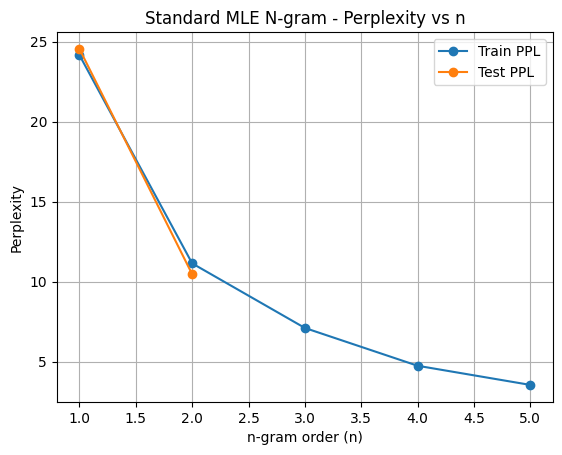

In [79]:
plot_ppl_vs_n(results, title="Standard MLE N-gram - Perplexity vs n")

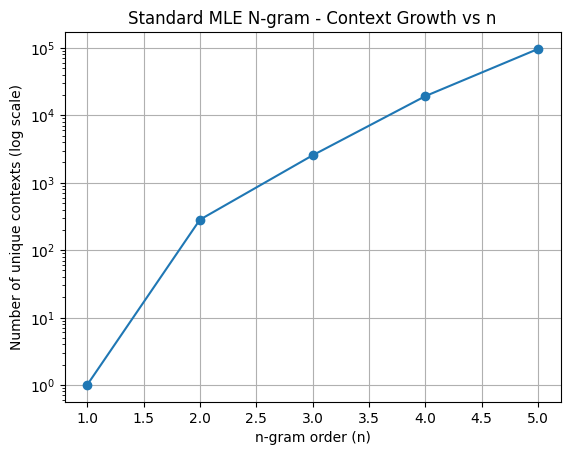

In [80]:
plot_context_growth(results, title="Standard MLE N-gram - Context Growth vs n")

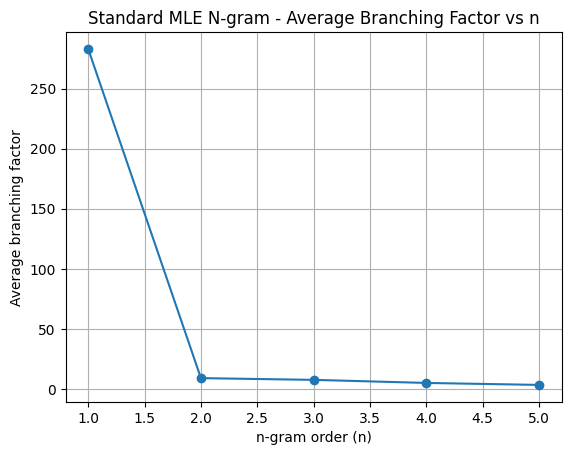

In [81]:
plot_avg_branching(results, title="Standard MLE N-gram - Average Branching Factor vs n")

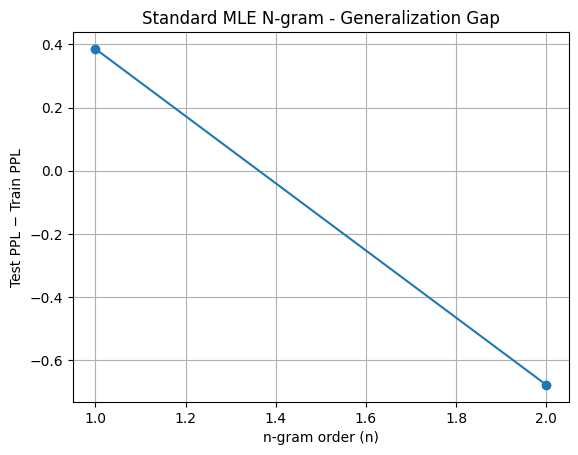

In [82]:
plot_generalization_gap(results, title="Standard MLE N-gram - Generalization Gap")

## MLE with Laplace Smoothing

In [26]:
# ---------- run experiments for n = 1..5 (Laplace smoothing) ----------

results_laplace = []

vocab_size = len(encoder)   # character vocabulary size

for n in range(1, 6):
    print("\n" + "=" * 60)
    print(f"Laplace-smoothed Character n-gram | n = {n}")
    print("=" * 60)

    # padded views
    train_seqs = pad_sequences(
        train_dataset.token_sequences,
        n=n,
        bos=encoder.BOS,
        eos=encoder.EOS
    )

    test_seqs = pad_sequences(
        test_dataset.token_sequences,
        n=n,
        bos=encoder.BOS,
        eos=encoder.EOS
    )

    # train
    lm = NgramLM(n)
    lm.fit(train_seqs)

    # bind estimator
    log_prob_fn = lambda ctx, tok: lm.log_prob_laplace(ctx, tok, vocab_size)

    # evaluate
    train_ppl = lm.perplexity(train_seqs, log_prob_fn)
    test_ppl  = lm.perplexity(test_seqs, log_prob_fn)

    num_contexts = len(lm.context_counts)
    avg_branching = (
        sum(len(v) for v in lm.counts.values()) / num_contexts
        if num_contexts > 0 else 0
    )

    print(f"Train PPL      : {train_ppl}")
    print(f"Test  PPL      : {test_ppl}")
    print(f"# Contexts     : {num_contexts}")
    print(f"Avg branching  : {avg_branching:.2f}")

    results_laplace.append({
        "n": n,
        "train_ppl": train_ppl,
        "test_ppl": test_ppl,
        "contexts": num_contexts,
        "avg_branching": avg_branching,
    })


Laplace-smoothed Character n-gram | n = 1
Train PPL      : 24.15309960397604
Test  PPL      : 24.53870589685895
# Contexts     : 1
Avg branching  : 283.00

Laplace-smoothed Character n-gram | n = 2
Train PPL      : 11.170862633369168
Test  PPL      : 10.489102414970223
# Contexts     : 283
Avg branching  : 9.03

Laplace-smoothed Character n-gram | n = 3
Train PPL      : 7.299731940884763
Test  PPL      : 6.72399583497204
# Contexts     : 2554
Avg branching  : 7.58

Laplace-smoothed Character n-gram | n = 4
Train PPL      : 5.5852180346622085
Test  PPL      : 5.18926975671282
# Contexts     : 19295
Avg branching  : 5.03

Laplace-smoothed Character n-gram | n = 5
Train PPL      : 5.8331263355020555
Test  PPL      : 5.5140121187774955
# Contexts     : 96782
Avg branching  : 3.38


In [33]:
print_results_table(results_laplace, name="MLE with Laplace Smoothing N-gram")


MLE with Laplace Smoothing N-gram
----------------------------------------------------------------------
 n  Train PPL  Test PPL  Contexts  Branch
 1     24.153    24.539         1 283.000
 2     11.171    10.489       283   9.028
 3      7.300     6.724      2554   7.583
 4      5.585     5.189     19295   5.032
 5      5.833     5.514     96782   3.376
Saved to MLE with Laplace Smoothing N-gram.csv


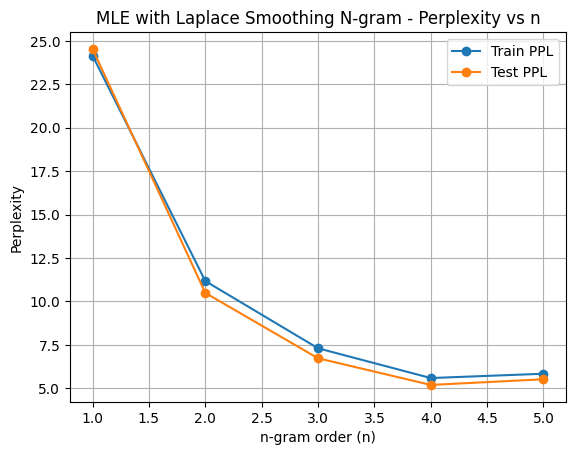

In [83]:
plot_ppl_vs_n(results_laplace, title="MLE with Laplace Smoothing N-gram - Perplexity vs n")

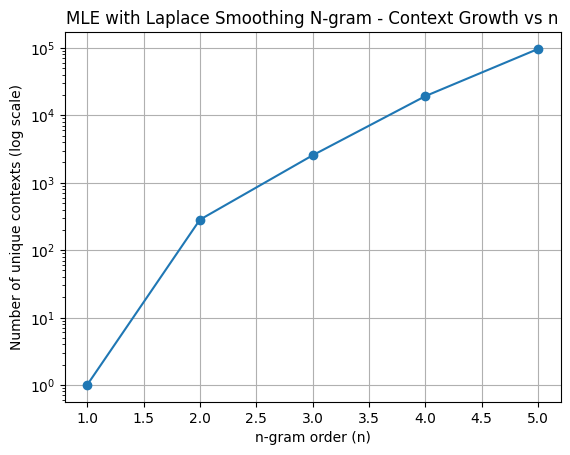

In [84]:
plot_context_growth(results_laplace, title="MLE with Laplace Smoothing N-gram - Context Growth vs n")

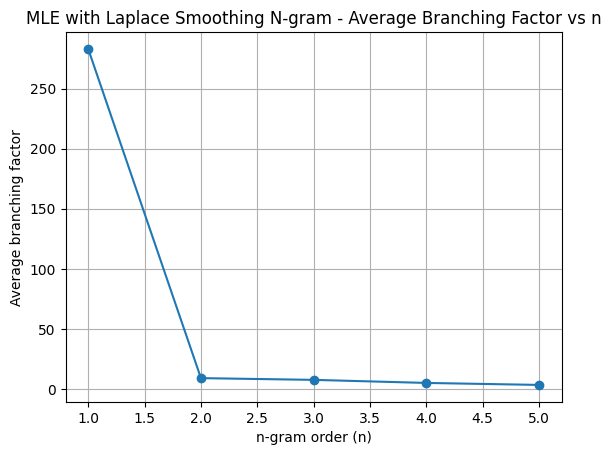

In [85]:
plot_avg_branching(results_laplace, title="MLE with Laplace Smoothing N-gram - Average Branching Factor vs n")

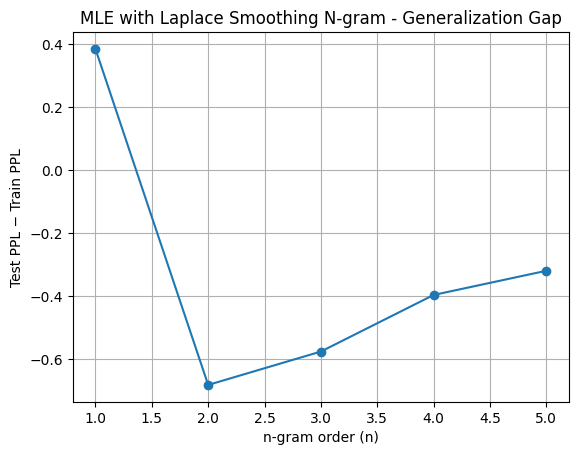

In [86]:
plot_generalization_gap(results_laplace, title="MLE with Laplace Smoothing N-gram - Generalization Gap")

## MLE with Add K Smoothing

In [41]:
# ---------- run experiments for n = 1..5 (Add-k smoothing) ----------

results_addk = {}  # {n: {k: result_dict}}

vocab_size = len(encoder)
ks = [0.01, 0.1, 0.5, 1]

for n in range(1, 6):
    results_addk[n] = {}
    for k in ks:
        print("\n" + "=" * 60)
        print(f"Add-k Character n-gram | n = {n} | k = {k}")
        print("=" * 60)
    
        train_seqs = pad_sequences(
            train_dataset.token_sequences,
            n=n,
            bos=encoder.BOS,
            eos=encoder.EOS
        )
    
        test_seqs = pad_sequences(
            test_dataset.token_sequences,
            n=n,
            bos=encoder.BOS,
            eos=encoder.EOS
        )
    
        lm = NgramLM(n)
        lm.fit(train_seqs)
    
        # bind estimator
        log_prob_fn = lambda ctx, tok: lm.log_prob_add_k(
            ctx, tok, vocab_size=vocab_size, k=k
        )
    
        train_ppl = lm.perplexity(train_seqs, log_prob_fn)
        test_ppl  = lm.perplexity(test_seqs, log_prob_fn)
    
        num_contexts = len(lm.context_counts)
        avg_branching = (
            sum(len(v) for v in lm.counts.values()) / num_contexts
            if num_contexts > 0 else 0
        )
    
        print(f"Train PPL      : {train_ppl}")
        print(f"Test  PPL      : {test_ppl}")
        print(f"# Contexts     : {num_contexts}")
        print(f"Avg branching  : {avg_branching:.2f}")
    
        # Store nicely: results_addk[n][k] = {...}
        results_addk[n][k] = {
            "n": n,
            "k": k,
            "train_ppl": train_ppl,
            "test_ppl": test_ppl,
            "contexts": num_contexts,
            "avg_branching": avg_branching,
        }


Add-k Character n-gram | n = 1 | k = 0.01
Train PPL      : 24.153061781772383
Test  PPL      : 24.53860085480424
# Contexts     : 1
Avg branching  : 283.00

Add-k Character n-gram | n = 1 | k = 0.1
Train PPL      : 24.15306239082726
Test  PPL      : 24.538608446216724
# Contexts     : 1
Avg branching  : 283.00

Add-k Character n-gram | n = 1 | k = 0.5
Train PPL      : 24.153072488386293
Test  PPL      : 24.53864718916723
# Contexts     : 1
Avg branching  : 283.00

Add-k Character n-gram | n = 1 | k = 1
Train PPL      : 24.15309960397604
Test  PPL      : 24.53870589685895
# Contexts     : 1
Avg branching  : 283.00

Add-k Character n-gram | n = 2 | k = 0.01
Train PPL      : 11.140876455615013
Test  PPL      : 10.463270153387581
# Contexts     : 283
Avg branching  : 9.03

Add-k Character n-gram | n = 2 | k = 0.1
Train PPL      : 11.144977538443365
Test  PPL      : 10.466785039052416
# Contexts     : 283
Avg branching  : 9.03

Add-k Character n-gram | n = 2 | k = 0.5
Train PPL      : 11.1

In [49]:
print_addk_results(results_addk, ks)


MLE with Add-K Smoothing N-gram (k=0.01)
----------------------------------------------------------------------
 n  Train PPL  Test PPL  Contexts  Branch
 1     24.153    24.539         1 283.000
 2     11.141    10.463       283   9.028
 3      7.110     6.582      2554   7.583
 4      4.765     4.548     19295   5.032
 5      3.620     3.738     96782   3.376
Saved to MLE with Add-K Smoothing N-gram (k=0.01).csv

MLE with Add-K Smoothing N-gram (k=0.1)
----------------------------------------------------------------------
 n  Train PPL  Test PPL  Contexts  Branch
 1     24.153    24.539         1 283.000
 2     11.145    10.467       283   9.028
 3      7.137     6.598      2554   7.583
 4      4.892     4.630     19295   5.032
 5      3.999     3.994     96782   3.376
Saved to MLE with Add-K Smoothing N-gram (k=0.1).csv

MLE with Add-K Smoothing N-gram (k=0.5)
----------------------------------------------------------------------
 n  Train PPL  Test PPL  Contexts  Branch
 1     24.

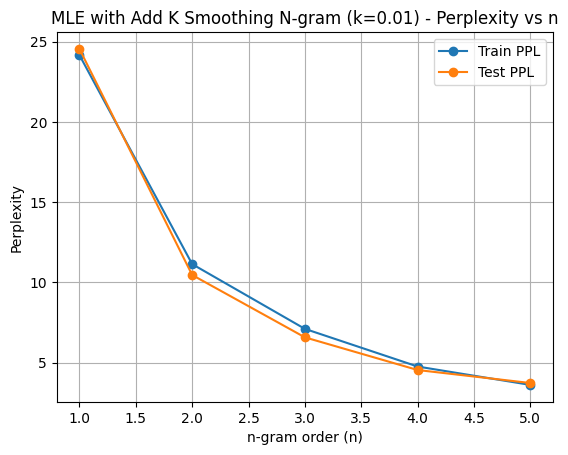

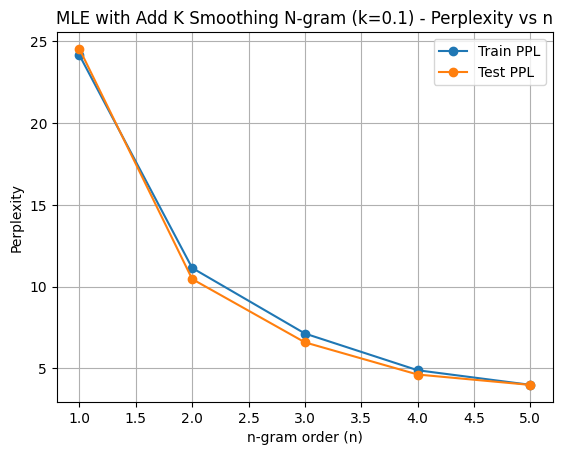

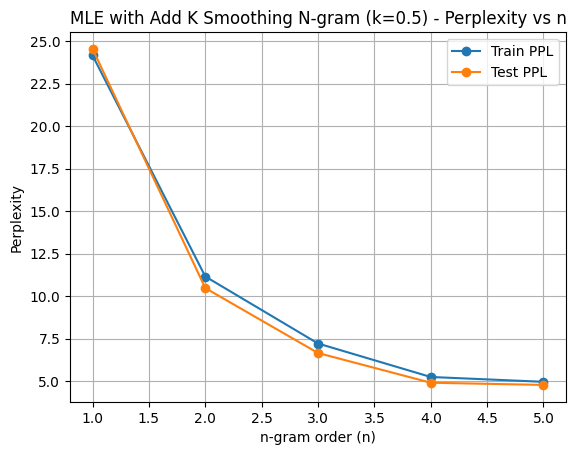

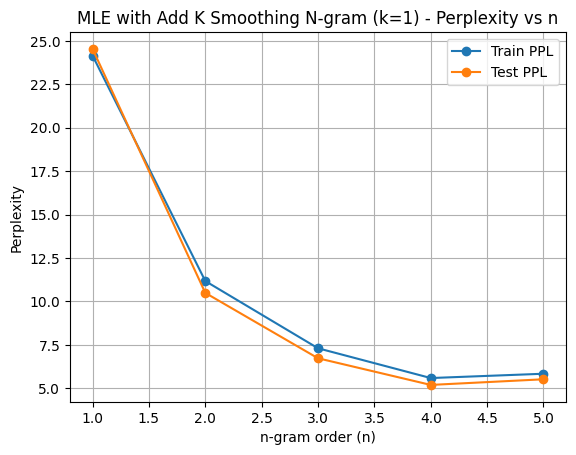

In [87]:
# Plot for each k (or specific ones)
ks = [0.01, 0.1, 0.5, 1]
for k in ks:
    k_results = get_k_results(results_addk, k)
    if k_results:
        title = f"MLE with Add K Smoothing N-gram (k={k}) - Perplexity vs n"
        plot_ppl_vs_n(k_results, title)

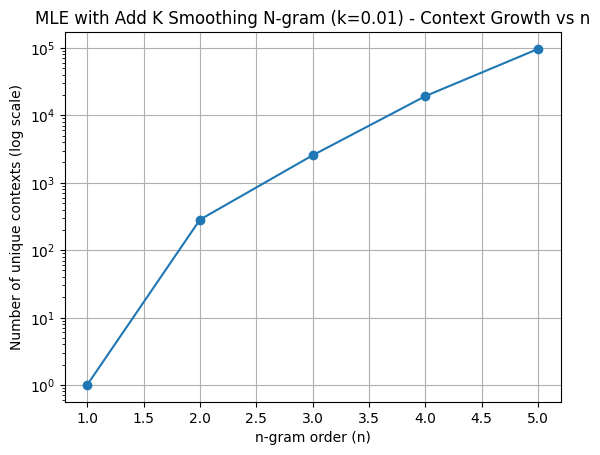

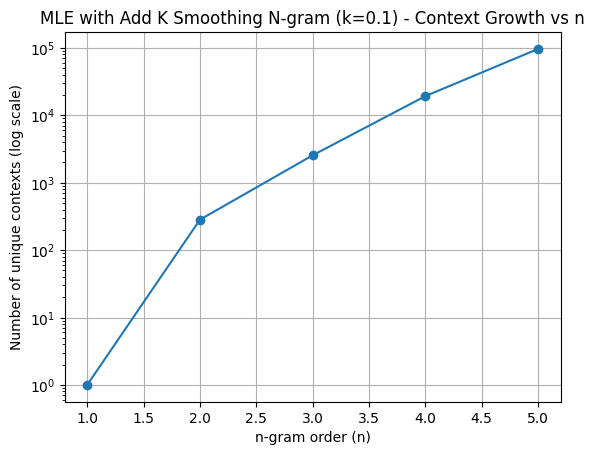

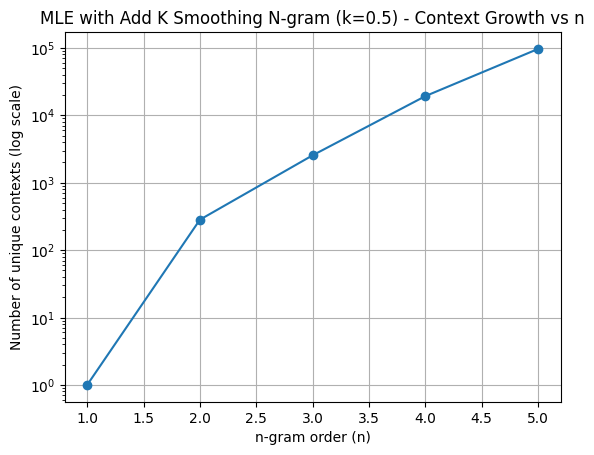

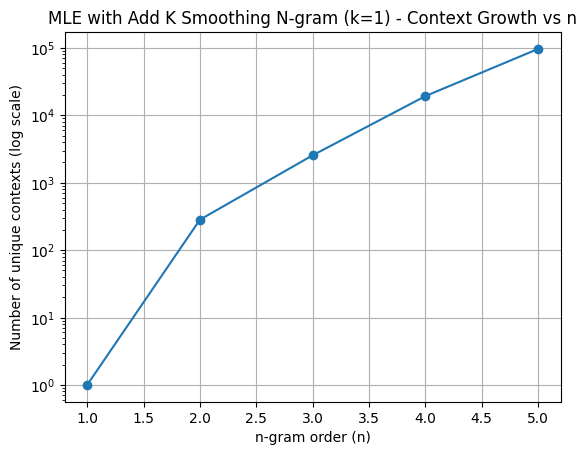

In [88]:
# Plot for each k (or specific ones)
ks = [0.01, 0.1, 0.5, 1]
for k in ks:
    k_results = get_k_results(results_addk, k)
    if k_results:
        title = f"MLE with Add K Smoothing N-gram (k={k}) - Context Growth vs n"
        plot_context_growth(k_results, title)

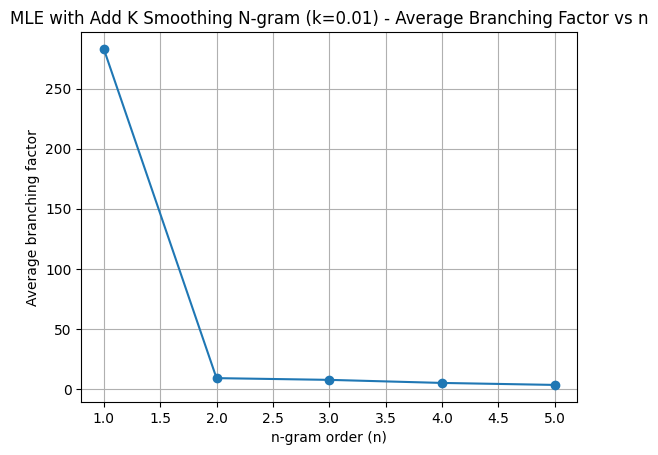

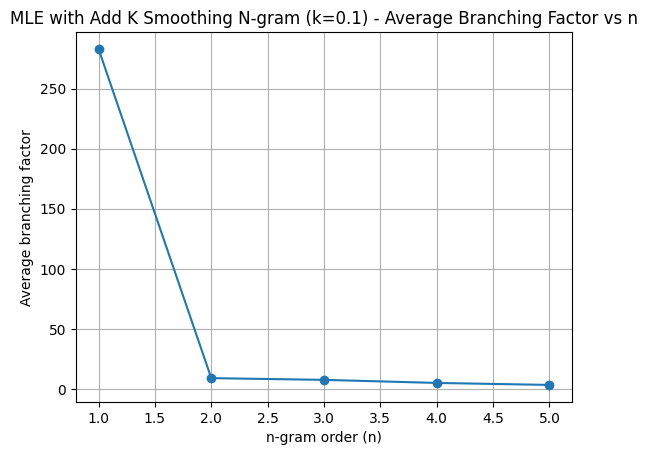

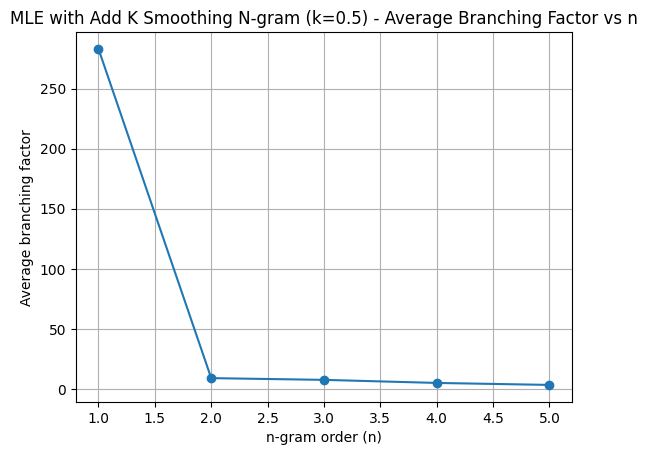

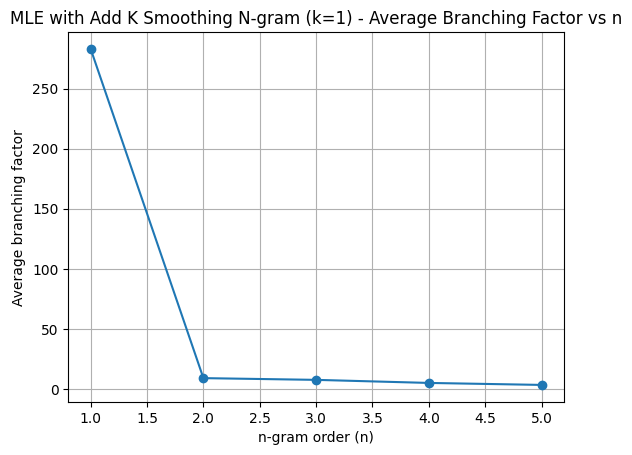

In [89]:
# Plot for each k (or specific ones)
ks = [0.01, 0.1, 0.5, 1]
for k in ks:
    k_results = get_k_results(results_addk, k)
    if k_results:
        title = f"MLE with Add K Smoothing N-gram (k={k}) - Average Branching Factor vs n"
        plot_avg_branching(k_results, title)

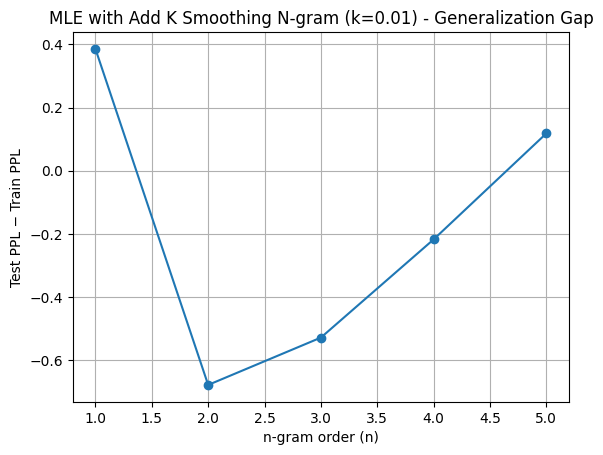

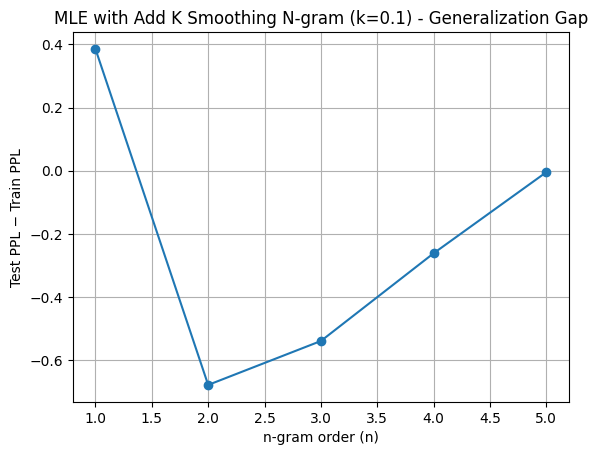

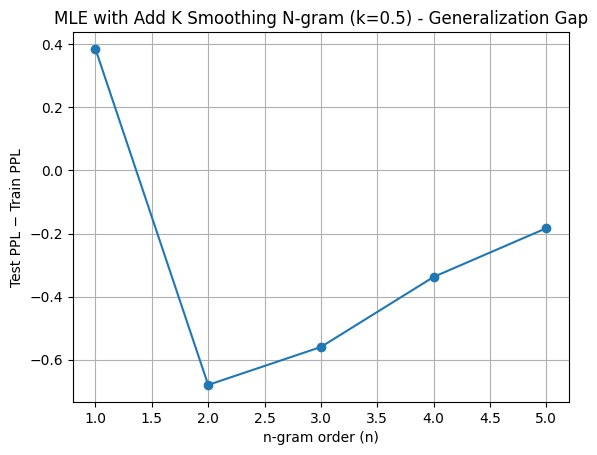

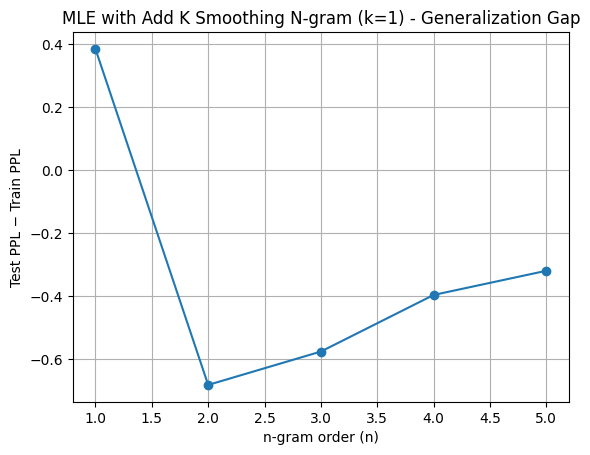

In [90]:
# Plot for each k (or specific ones)
ks = [0.01, 0.1, 0.5, 1]
for k in ks:
    k_results = get_k_results(results_addk, k)
    if k_results:
        title = f"MLE with Add K Smoothing N-gram (k={k}) - Generalization Gap"
        plot_generalization_gap(k_results, title)

## Linear Interpolation

In [55]:
# ---------- run experiments for n = 1..5 (Linear Interpolation) ----------

results_interp = []

# simple heuristic lambdas per n
lambda_map = {
    1: [1.0],
    2: [0.3, 0.7],
    3: [0.2, 0.3, 0.5],
    4: [0.1, 0.2, 0.3, 0.4],
    5: [0.05, 0.1, 0.2, 0.25, 0.4],
}

for n in range(1, 6):
    print("\n" + "=" * 60)
    print(f"Interpolated Character n-gram | n = {n}")
    print("=" * 60)

    lambdas = lambda_map[n]
    assert len(lambdas) == n
    assert abs(sum(lambdas) - 1.0) < 1e-6

    # padded views
    train_seqs = pad_sequences(
        train_dataset.token_sequences,
        n=n,
        bos=encoder.BOS,
        eos=encoder.EOS
    )

    test_seqs = pad_sequences(
        test_dataset.token_sequences,
        n=n,
        bos=encoder.BOS,
        eos=encoder.EOS
    )

    # train
    lm = NgramLM(n)
    lm.fit(train_seqs)

    # bind interpolated estimator
    log_prob_fn = lambda ctx, tok: lm.log_prob_interpolated(
        ctx, tok, lambdas=lambdas, vocab_size=len(encoder), k=0.01
    )

    # evaluate
    train_ppl = lm.perplexity(train_seqs, log_prob_fn)
    test_ppl  = lm.perplexity(test_seqs, log_prob_fn)

    num_contexts = len(lm.context_counts)
    avg_branching = (
        sum(len(v) for v in lm.counts.values()) / num_contexts
        if num_contexts > 0 else 0
    )

    print(f"Lambdas        : {lambdas}")
    print(f"Train PPL      : {train_ppl}")
    print(f"Test  PPL      : {test_ppl}")
    print(f"# Contexts     : {num_contexts}")
    print(f"Avg branching  : {avg_branching:.2f}")

    results_interp.append({
        "n": n,
        "lambdas": lambdas,
        "train_ppl": train_ppl,
        "test_ppl": test_ppl,
        "contexts": num_contexts,
        "avg_branching": avg_branching,
    })


Interpolated Character n-gram | n = 1
Lambdas        : [1.0]
Train PPL      : 24.153061781772397
Test  PPL      : 24.53860085480424
# Contexts     : 1
Avg branching  : 283.00

Interpolated Character n-gram | n = 2
Lambdas        : [0.3, 0.7]
Train PPL      : 15.217927179388054
Test  PPL      : 14.346783203560458
# Contexts     : 283
Avg branching  : 9.03

Interpolated Character n-gram | n = 3
Lambdas        : [0.2, 0.3, 0.5]
Train PPL      : 13.74856279246113
Test  PPL      : 12.755455724501351
# Contexts     : 2554
Avg branching  : 7.58

Interpolated Character n-gram | n = 4
Lambdas        : [0.1, 0.2, 0.3, 0.4]
Train PPL      : 11.66432319519256
Test  PPL      : 11.116271566130534
# Contexts     : 19295
Avg branching  : 5.03

Interpolated Character n-gram | n = 5
Lambdas        : [0.05, 0.1, 0.2, 0.25, 0.4]
Train PPL      : 8.809711667312854
Test  PPL      : 9.148885028134808
# Contexts     : 96782
Avg branching  : 3.38


In [61]:
print_results_table(results_interp, "MLE with Linear Interpolation")


MLE with Linear Interpolation
------------------------------------------------------------------------------
                    Lambdas  N  Train Ppl  Test Ppl  Contexts  Avg Branching
                      [1.0]  1     24.153    24.539         1        283.000
                 [0.3, 0.7]  2     15.218    14.347       283          9.028
            [0.2, 0.3, 0.5]  3     13.749    12.755      2554          7.583
       [0.1, 0.2, 0.3, 0.4]  4     11.664    11.116     19295          5.032
[0.05, 0.1, 0.2, 0.25, 0.4]  5      8.810     9.149     96782          3.376
Saved to MLE with Linear Interpolation.csv (cols: Lambdas, N, Train Ppl, Test Ppl, Contexts, Avg Branching)


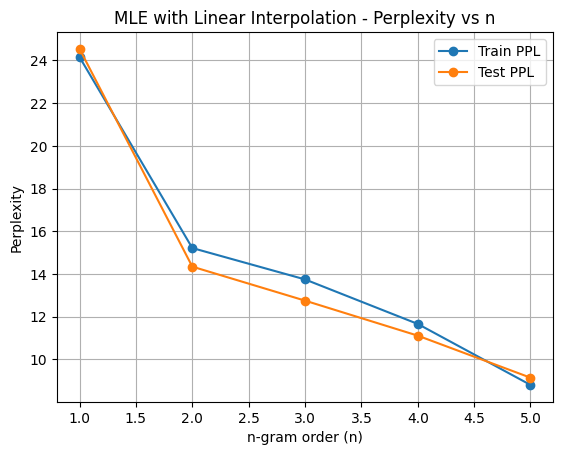

In [91]:
plot_ppl_vs_n(results_interp, "MLE with Linear Interpolation - Perplexity vs n")

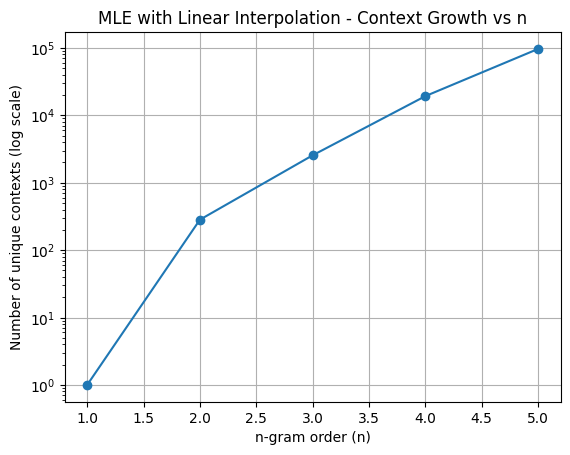

In [92]:
plot_context_growth(results_interp, "MLE with Linear Interpolation - Context Growth vs n")

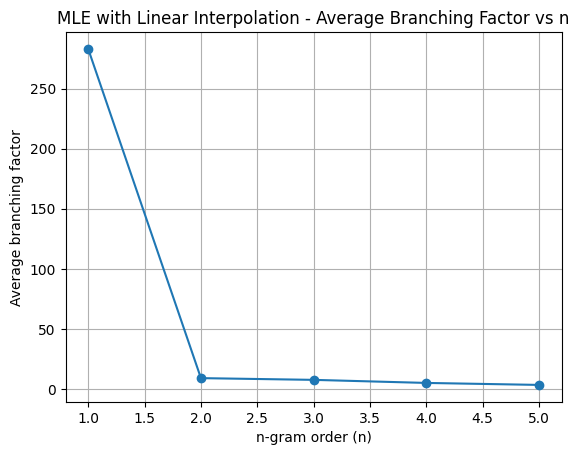

In [93]:
plot_avg_branching(results_interp, "MLE with Linear Interpolation - Average Branching Factor vs n")

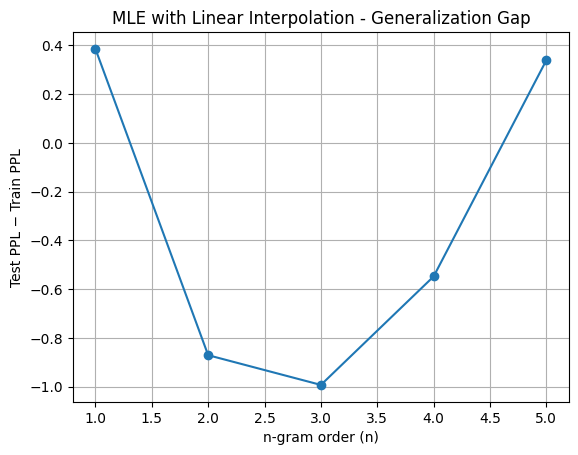

In [94]:
plot_generalization_gap(results_interp, "MLE with Linear Interpolation - Generalization Gap")

## Stupid Backoff

In [66]:
# ---------- run experiments for n = 1..5 (Stupid Backoff) ----------

results_backoff = []

alpha = 0.4  # standard value from Brants et al.

for n in range(1, 6):
    print("\n" + "=" * 60)
    print(f"Stupid Backoff Character n-gram | n = {n}")
    print("=" * 60)

    # padded views
    train_seqs = pad_sequences(
        train_dataset.token_sequences,
        n=n,
        bos=encoder.BOS,
        eos=encoder.EOS
    )

    test_seqs = pad_sequences(
        test_dataset.token_sequences,
        n=n,
        bos=encoder.BOS,
        eos=encoder.EOS
    )

    # train
    lm = NgramLM(n)
    lm.fit(train_seqs)

    # bind backoff estimator
    log_prob_fn = lambda ctx, tok: lm.log_prob_backoff(
        ctx, tok, alpha=alpha, vocab_size=len(encoder), k=0.01
    )

    # evaluate
    train_ppl = lm.perplexity(train_seqs, log_prob_fn)
    test_ppl  = lm.perplexity(test_seqs, log_prob_fn)

    num_contexts = len(lm.context_counts)
    avg_branching = (
        sum(len(v) for v in lm.counts.values()) / num_contexts
        if num_contexts > 0 else 0
    )

    print(f"Alpha          : {alpha}")
    print(f"Train PPL      : {train_ppl}")
    print(f"Test  PPL      : {test_ppl}")
    print(f"# Contexts     : {num_contexts}")
    print(f"Avg branching  : {avg_branching:.2f}")

    results_backoff.append({
        "n": n,
        "alpha": alpha,
        "train_ppl": train_ppl,
        "test_ppl": test_ppl,
        "contexts": num_contexts,
        "avg_branching": avg_branching,
    })


Stupid Backoff Character n-gram | n = 1
Alpha          : 0.4
Train PPL      : 24.153061781772397
Test  PPL      : 24.53860085480424
# Contexts     : 1
Avg branching  : 283.00

Stupid Backoff Character n-gram | n = 2
Alpha          : 0.4
Train PPL      : 11.140178202475115
Test  PPL      : 10.462674866198304
# Contexts     : 283
Avg branching  : 9.03

Stupid Backoff Character n-gram | n = 3
Alpha          : 0.4
Train PPL      : 7.105696409200527
Test  PPL      : 6.5719678438201985
# Contexts     : 2554
Avg branching  : 7.58

Stupid Backoff Character n-gram | n = 4
Alpha          : 0.4
Train PPL      : 4.744557284026341
Test  PPL      : 4.504223685539158
# Contexts     : 19295
Avg branching  : 5.03

Stupid Backoff Character n-gram | n = 5
Alpha          : 0.4
Train PPL      : 3.5481889646065463
Test  PPL      : 3.605194357686556
# Contexts     : 96782
Avg branching  : 3.38


In [67]:
print_results_table(results_backoff, name="MLE with Stupid Backoff N-gram")


MLE with Stupid Backoff N-gram
------------------------------------------------------------------------------
 Alpha  N  Train Ppl  Test Ppl  Contexts  Avg Branching
 0.400  1     24.153    24.539         1        283.000
 0.400  2     11.140    10.463       283          9.028
 0.400  3      7.106     6.572      2554          7.583
 0.400  4      4.745     4.504     19295          5.032
 0.400  5      3.548     3.605     96782          3.376
Saved to MLE with Stupid Backoff N-gram.csv (cols: Alpha, N, Train Ppl, Test Ppl, Contexts, Avg Branching)


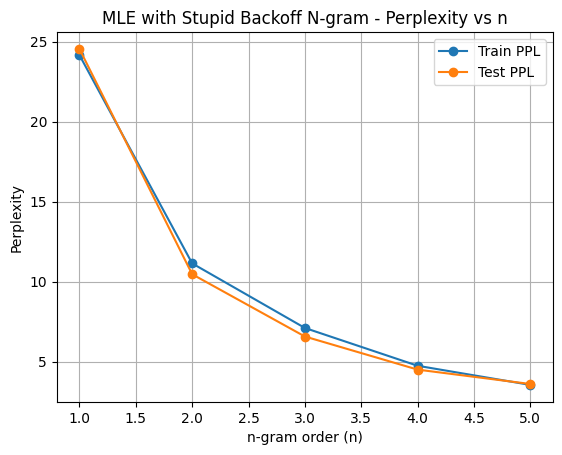

In [95]:
plot_ppl_vs_n(results_backoff, title="MLE with Stupid Backoff N-gram - Perplexity vs n")

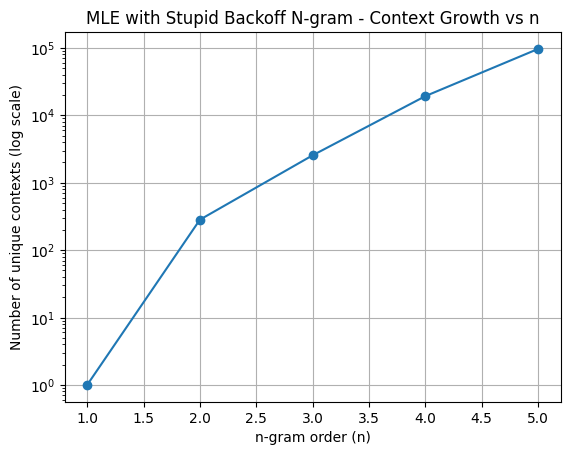

In [96]:
plot_context_growth(results_backoff, title="MLE with Stupid Backoff N-gram - Context Growth vs n")

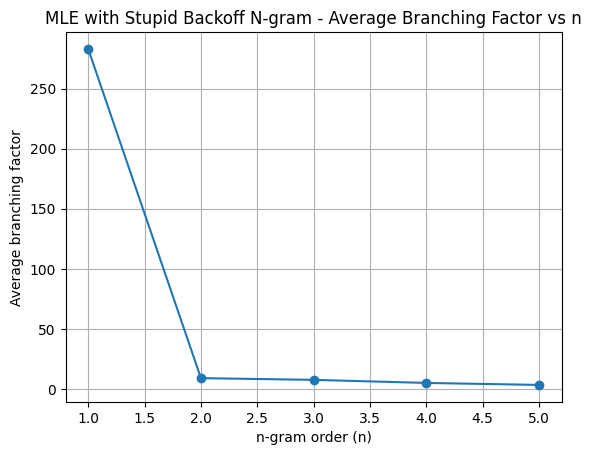

In [97]:
plot_avg_branching(results_backoff, title="MLE with Stupid Backoff N-gram - Average Branching Factor vs n")

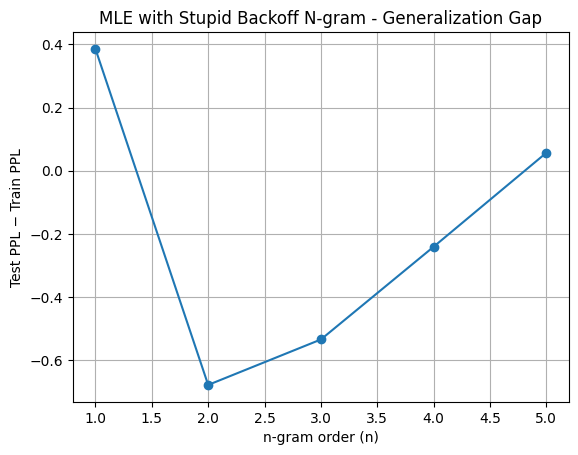

In [98]:
plot_generalization_gap(results_backoff, title="MLE with Stupid Backoff N-gram - Generalization Gap")

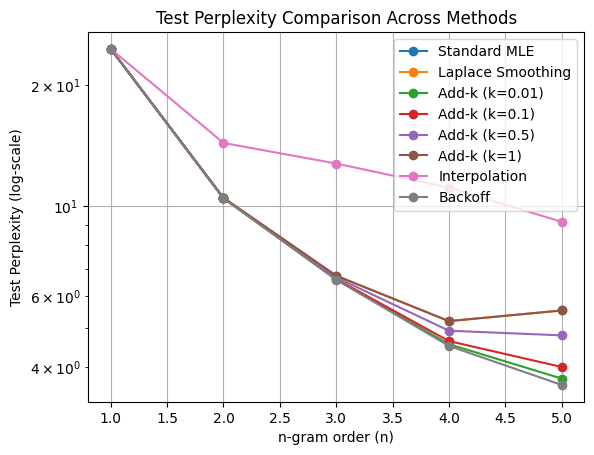

In [99]:
# Flatten all nested/individual results to lists for unpack_results
results_dict = {
    "Standard MLE": results,
    "Laplace Smoothing": results_laplace,
    "Add-k (k=0.01)": get_k_results(results_addk, 0.01),
    "Add-k (k=0.1)": get_k_results(results_addk, 0.1),
    "Add-k (k=0.5)": get_k_results(results_addk, 0.5),
    "Add-k (k=1)": get_k_results(results_addk, 1),
    "Interpolation": results_interp,
    "Backoff": results_backoff
}

plot_test_ppl_comparison(results_dict, "Test Perplexity Comparison Across Methods")
